# Intro Task, Object Localization

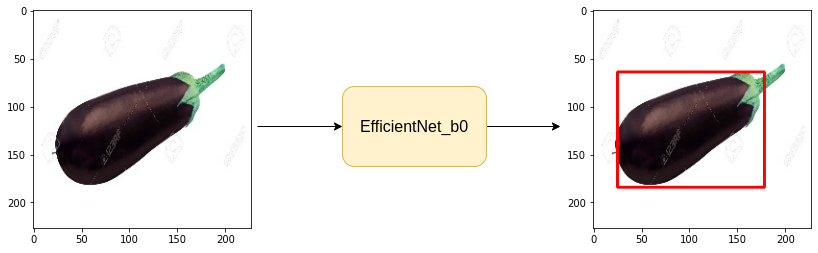

In [2]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python
!pip install albucore==0.0.23
!pip install -U albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ikyks68d
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ikyks68d
  Resolved https://github.com/albumentations-team/albumentations to commit 190ce313a143689e59ca727f799b729078a89285
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.23
    Uninstalling albucore-0.0.23:
      Successfully uninstalled albucore-0.0.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.5 requires albucore==0.0.23, but you hav

In [3]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 2.73 MiB | 29.48 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [6]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [7]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

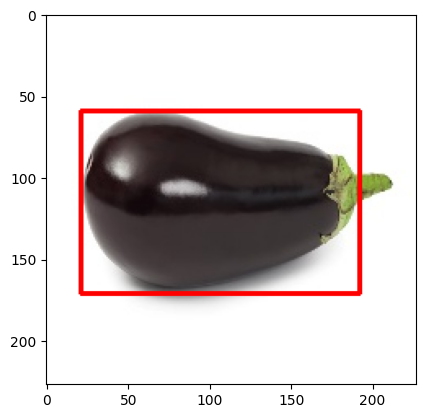

In [8]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)

bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Augmentations

In [10]:
import albumentations as A

In [11]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))


valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))


# Create Custom Dataset

In [12]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2, 0, 1) /255.0  #(h, w, c) -> (c, h, w)
    bbox = torch.Tensor(bbox)

    return img, bbox

In [13]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [14]:
print(f"Total examples in the trainset : {len(trainset)}")
print(f"Total examples in the validset : {len(validset)}")

Total examples in the trainset : 148
Total examples in the validset : 38


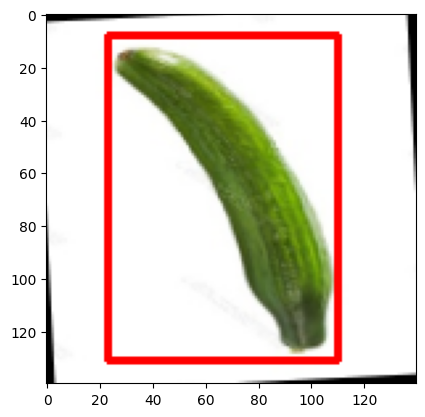

In [15]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0), 2)
plt.imshow(bnd_img)

# Load dataset into batches

In [16]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [17]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [18]:
for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [19]:
from torch import nn
import timm

In [20]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

  def forward(self, images, gt_bboxes = None):

    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes

In [21]:
model = ObjLocModel()
model.to(DEVICE);

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [22]:
random_img = torch.rand(1,3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [29]:
def train_fn(model, dataloader, optimizer):

  model.train() #Dropout ON
  total_loss = 0.0

  for data in tqdm(dataloader):

    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [30]:
def eval_fn(model, dataloader):

  model.eval() #Dropout OFF
  total_loss = 0.0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()

    return total_loss / len(dataloader)

#Training Loop

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [31]:
best_valid_loss = np.inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('WEIGHTS ARE SAVED')
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1}  train_loss : {train_loss}  valid_loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 1  train_loss : 1959.5986572265624  valid_loss : 3676.2000325520835


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 2  train_loss : 1113.317236328125  valid_loss : 333.5450948079427


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 3  train_loss : 670.6624176025391  valid_loss : 143.69046020507812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4  train_loss : 483.7606719970703  valid_loss : 172.02657063802084


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5  train_loss : 380.18720703125  valid_loss : 224.38450876871744


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6  train_loss : 273.05217895507815  valid_loss : 176.7193857828776


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 7  train_loss : 218.29079895019532  valid_loss : 134.63534545898438


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8  train_loss : 164.75811691284179  valid_loss : 137.10733540852866


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 9  train_loss : 148.00454750061036  valid_loss : 110.15337626139323


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10  train_loss : 121.74402618408203  valid_loss : 136.98847198486328


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 11  train_loss : 99.36088523864746  valid_loss : 97.46068318684895


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 12  train_loss : 85.98613014221192  valid_loss : 98.35837046305339


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 13  train_loss : 86.5665283203125  valid_loss : 94.34093729654948


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14  train_loss : 82.42387161254882  valid_loss : 103.93576558430989


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 15  train_loss : 75.29043884277344  valid_loss : 104.3203239440918


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 16  train_loss : 78.95334053039551  valid_loss : 88.44708760579427


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 17  train_loss : 71.12328224182129  valid_loss : 76.76556905110677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18  train_loss : 78.80991020202637  valid_loss : 85.62406667073567


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 19  train_loss : 61.609022521972655  valid_loss : 74.5774777730306


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 20  train_loss : 51.782799911499026  valid_loss : 76.34138870239258


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 21  train_loss : 52.46065464019775  valid_loss : 52.77739588419596


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22  train_loss : 51.41195220947266  valid_loss : 63.419148763020836


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 23  train_loss : 52.57974796295166  valid_loss : 50.38695780436198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24  train_loss : 51.83988265991211  valid_loss : 76.46789423624675


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25  train_loss : 47.673788452148436  valid_loss : 77.04618326822917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26  train_loss : 54.3976411819458  valid_loss : 70.62680562337239


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27  train_loss : 50.150447082519534  valid_loss : 61.89049530029297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28  train_loss : 35.46894359588623  valid_loss : 61.45433044433594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29  train_loss : 40.69692211151123  valid_loss : 64.09096399943034


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30  train_loss : 37.492648696899415  valid_loss : 76.87235005696614


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31  train_loss : 37.87411308288574  valid_loss : 61.48811594645182


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32  train_loss : 33.68529930114746  valid_loss : 53.70648447672526


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 33  train_loss : 50.21639976501465  valid_loss : 47.24316914876302


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 34  train_loss : 59.74844064712524  valid_loss : 38.309715270996094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35  train_loss : 47.02795352935791  valid_loss : 81.40072123209636


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36  train_loss : 43.86953334808349  valid_loss : 69.79858907063802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37  train_loss : 30.327290058135986  valid_loss : 50.2352040608724


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38  train_loss : 45.92523593902588  valid_loss : 45.921016693115234


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39  train_loss : 40.20178852081299  valid_loss : 39.514764149983726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 40  train_loss : 24.73625135421753  valid_loss : 36.98067092895508


#Inference

In [32]:
import utils

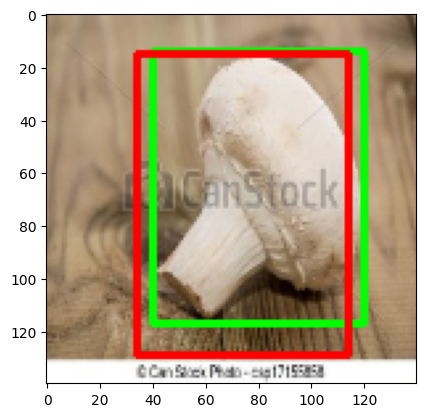

In [34]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


with torch.no_grad():
  image, gt_bbox = validset[23]  #(c,h,w)
  image = image.unsqueeze(0).to(DEVICE) #(bs,c,h,w)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)


# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya